In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
import lightgbm as lgb

### Предобработка данных

Видимо в основном соревновании стоит пресет, я его просто скопировал

Посмотрим как поделены данные в файлах

In [2]:
import os
import polars as pl

train_dir = 'parquet_files/train'
parquet_files = [f for f in os.listdir(train_dir) if f.endswith('.parquet')]

test_df = pl.read_parquet('parquet_files/test_base_table.parquet')
test_case_ids = test_df['case_id'].unique()
train_df = pl.read_parquet('parquet_files/train_base_table.parquet')
train_case_ids = train_df['case_id'].unique()

results = {}

for file in parquet_files:
    file_path = os.path.join(train_dir, file)
    train_df = pl.read_parquet(file_path)

    if 'case_id' in train_df.columns:
        contains_test_ids = train_df['case_id'].is_in(test_case_ids).any()
        contains_train_ids = train_df['case_id'].is_in(train_case_ids).any()
        
        if contains_test_ids and contains_train_ids:
            results[file] = "Contains both test and train case_ids"
        elif contains_test_ids:
            results[file] = "Contains test case_ids only"
        elif contains_train_ids:
            results[file] = "Contains train case_ids only"
        else:
            results[file] = "Does not contain any test or train case_ids"
    else:
        results[file] = "No 'case_id' column"

for file, result in results.items():
    print(f"{file}: {result}")


train_applprev_1_0.parquet: Contains train case_ids only
train_applprev_1_1.parquet: Contains both test and train case_ids
train_applprev_2.parquet: Contains both test and train case_ids
train_base.parquet: Contains both test and train case_ids
train_credit_bureau_a_1_0.parquet: Contains train case_ids only
train_credit_bureau_a_1_1.parquet: Contains train case_ids only
train_credit_bureau_a_1_2.parquet: Contains both test and train case_ids
train_credit_bureau_a_1_3.parquet: Contains test case_ids only
train_credit_bureau_a_2_0.parquet: Contains train case_ids only
train_credit_bureau_a_2_1.parquet: Contains train case_ids only
train_credit_bureau_a_2_10.parquet: Contains test case_ids only
train_credit_bureau_a_2_2.parquet: Contains train case_ids only
train_credit_bureau_a_2_3.parquet: Contains train case_ids only
train_credit_bureau_a_2_4.parquet: Contains train case_ids only
train_credit_bureau_a_2_5.parquet: Contains train case_ids only
train_credit_bureau_a_2_6.parquet: Contains

In [3]:
current_submission = 2

In [4]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df


class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
ROOT            = Path("parquet_files")

TRAIN_DIR       = ROOT / "train"

In [6]:
data_store = {
    "df_base": read_file(ROOT / "train_base_table.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [7]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

train data shape:	 (1219149, 861)
Memory usage of dataframe is 3447.38 MB
Memory usage after optimization is: 1203.42 MB
Decreased by 65.1%
train data shape:	 (1219149, 471)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt12m_3712952L', 'clientscnt_100L', 'clientscnt_1022L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupation

In [8]:
data_store = {
    "df_base": read_file(ROOT / "test_base_table.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [9]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)
train_df = df_train
test_df = df_test
drop_cols = []

gc.collect()

test data shape:	 (307510, 860)
train data shape:	 (1219149, 389)
test data shape:	 (307510, 388)
Memory usage of dataframe is 676.32 MB
Memory usage after optimization is: 258.42 MB
Decreased by 61.8%


0

### MLflow

Использование mlflow в своих исследованиях (до 5 баллов).

MLflow использовался мною для :
1. организация экспериментов
2. Дальнейшее использование модели
3. Логгирование

In [10]:
import optuna
import mlflow
import shap

In [12]:
mlflow.set_experiment("lightgbm_experiment")

<Experiment: artifact_location='file:///c:/Users/FUAD/Documents/MEGA/AI_MASTERS/Sem_2/ML_2/HW3/mlruns/420978505456890516', creation_time=1713284045424, experiment_id='420978505456890516', last_update_time=1713284045424, lifecycle_stage='active', name='lightgbm_experiment', tags={}>

In [69]:
X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)
print("X shape: ", X.shape)
y = train_df["target"]
weeks = train_df["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

X shape:  (1219149, 386)


In [88]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.25, step=0.1)
    params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": max_depth,
        "max_bin": 255,
        "learning_rate": learning_rate,
        "n_estimators": 1000,
        "colsample_bytree": 0.8,
        "colsample_bynode": 0.8,
        "verbose": -1,
        "random_state": 42,
        "device": "cpu",
        "num_thread": 2,
    }

    with mlflow.start_run():
        oof_pred = np.zeros(X.shape[0])
        for idx_train, idx_valid in cv.split(X, y, groups=weeks):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                      callbacks=[lgb.early_stopping(10)])
            val_pred = model.predict_proba(X_valid)[:, 1]
            oof_pred[idx_valid] = val_pred

        # Логируем параметры и метрики
        auc_score = roc_auc_score(y, oof_pred)
        mlflow.log_params(params)
        mlflow.log_metric('auc', auc_score)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_valid)

        # SHAP Summary Bee Swarm Plot
        plt.figure()
        shap.summary_plot(shap_values[1], X_valid, plot_type="dot", max_display=X_valid.shape[1], show=False)
        plt.savefig('shap_summary_bee_swarm.png')
        mlflow.log_artifact('shap_summary_bee_swarm.png')

        # Feature Importance
        plt.figure()
        lgb.plot_importance(model, max_num_features=X_valid.shape[1], importance_type='gain')
        plt.savefig('feature_importance.png')
        mlflow.log_artifact('feature_importance.png')

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_valid, val_pred)
        roc_auc_value = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_value)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve.png')
        mlflow.log_artifact('roc_curve.png')
        plt.close('all')

        return auc_score

In [89]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Best params: ", best_params)

with mlflow.start_run(run_name="Here_we_go_again"):
    model = lgb.LGBMClassifier(**best_params)
    model.fit(X, y)
    mlflow.sklearn.log_model(model, "model")

[I 2024-04-16 21:41:40,127] A new study created in memory with name: no-name-f8643ce8-7f43-419a-a6ae-c7d6b0062d83


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[329]	valid_0's auc: 0.845377
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[367]	valid_0's auc: 0.851302
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[478]	valid_0's auc: 0.846408
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[356]	valid_0's auc: 0.852027
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[477]	valid_0's auc: 0.849166


[I 2024-04-16 22:05:48,515] Trial 0 finished with value: 0.8490719786368479 and parameters: {'max_depth': 10, 'learning_rate': 0.05}. Best is trial 0 with value: 0.8490719786368479.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[178]	valid_0's auc: 0.842982
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.847661
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's auc: 0.843457
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.85012
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.846245


[I 2024-04-16 22:23:40,855] Trial 1 finished with value: 0.846337329002404 and parameters: {'max_depth': 6, 'learning_rate': 0.15000000000000002}. Best is trial 0 with value: 0.8490719786368479.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.83803
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.842516
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.838718
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.844395
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.842139


[I 2024-04-16 22:41:38,446] Trial 2 finished with value: 0.841384988996499 and parameters: {'max_depth': 10, 'learning_rate': 0.25}. Best is trial 0 with value: 0.8490719786368479.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.838405
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.844011
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.839873
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.844633
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.842402


[I 2024-04-16 22:55:13,279] Trial 3 finished with value: 0.8420651101463118 and parameters: {'max_depth': 8, 'learning_rate': 0.25}. Best is trial 0 with value: 0.8490719786368479.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[224]	valid_0's auc: 0.843101
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[136]	valid_0's auc: 0.846303
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[200]	valid_0's auc: 0.843997
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[198]	valid_0's auc: 0.849156
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[186]	valid_0's auc: 0.845538


В MLflow были собраны данные об экспериментах и сохранены графики shap, feature_importnace и roc кривой. По результатам оптимизации были выбраны параметры max_depth : 8, leanring_rate : 0.05. Собственно бэйслайн был составлен с этими параметрами.

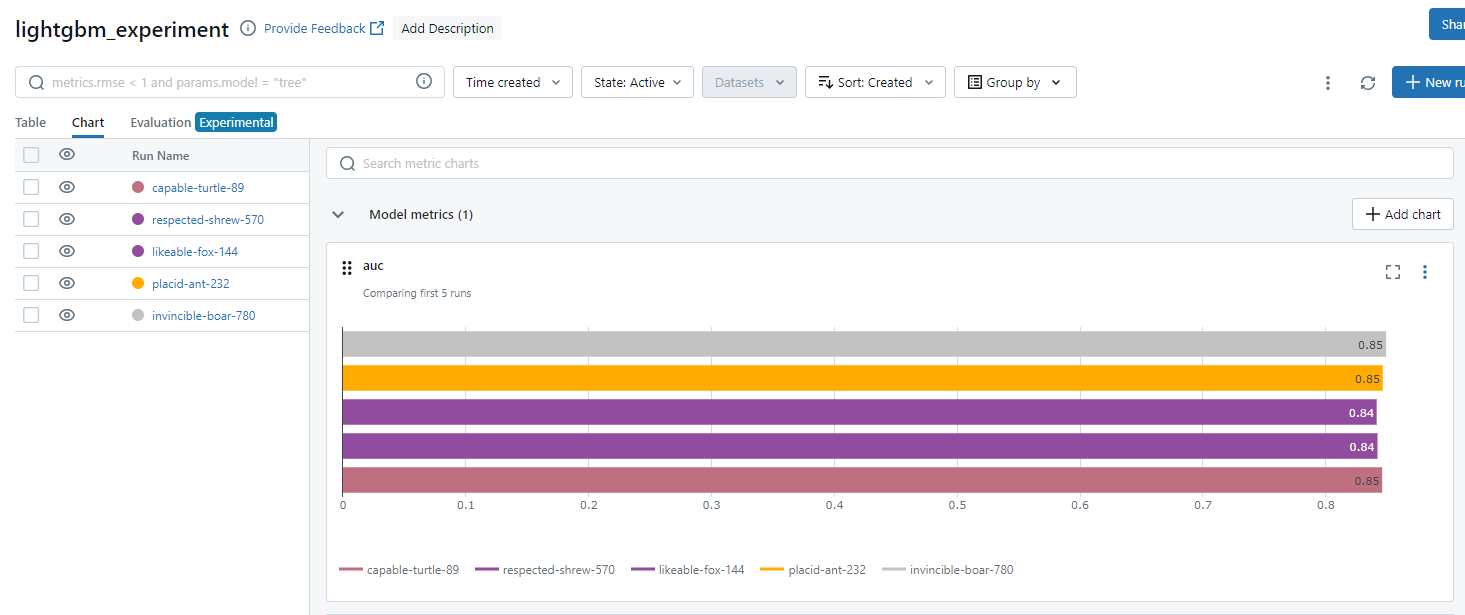

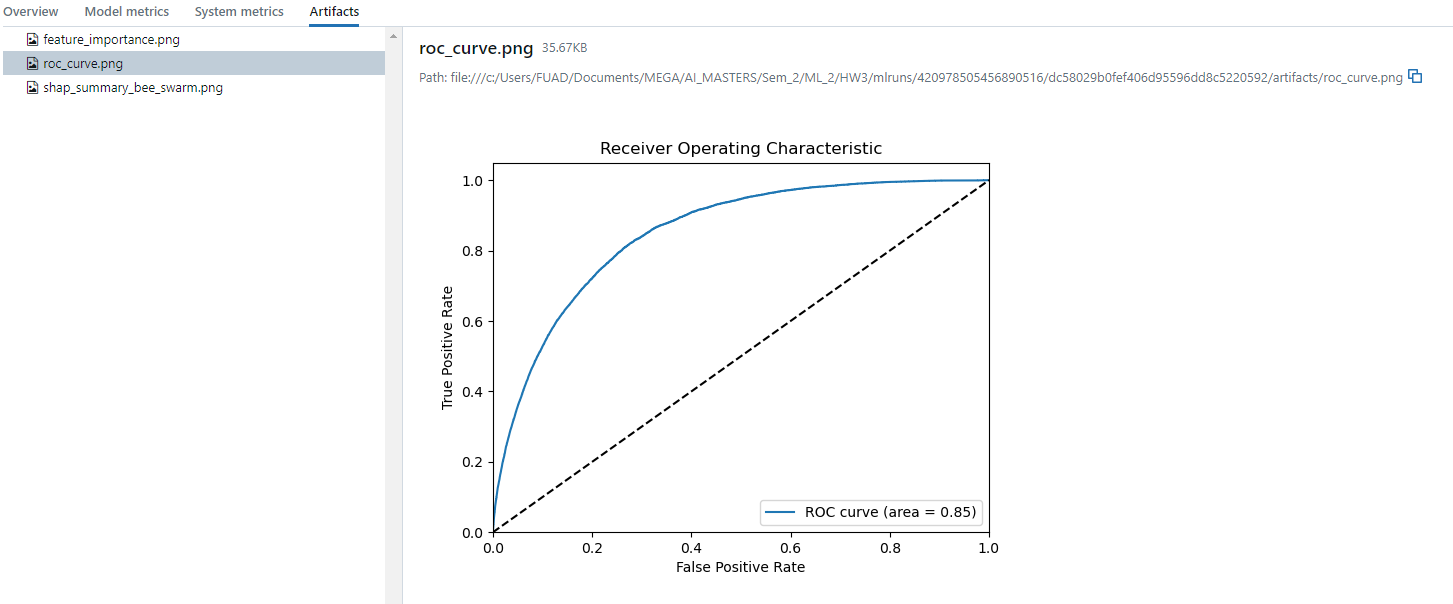

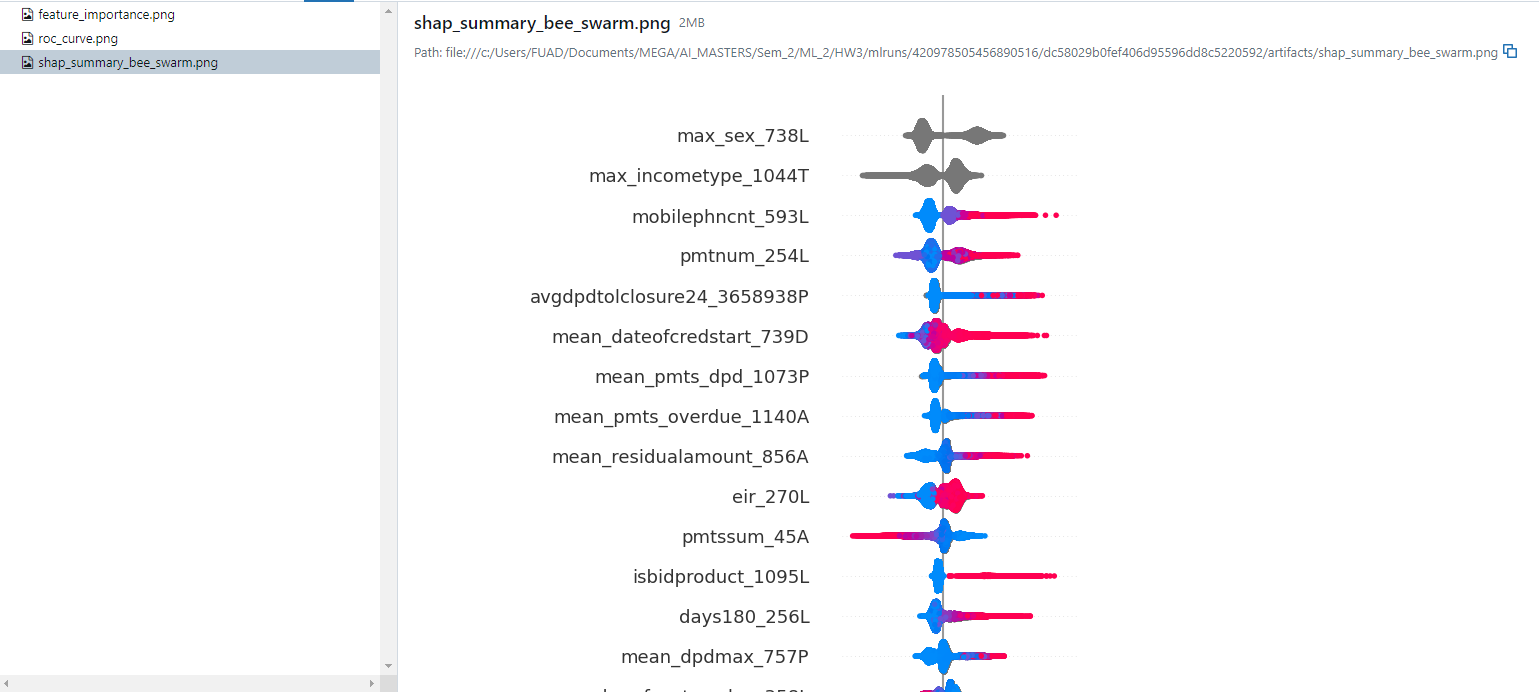

### 0. Baseline

Пробите 1,2 бейслайна (1+4 = 5 баллов)

In [13]:
mlflow.set_experiment("baseline")

2024/04/17 01:33:13 INFO mlflow.tracking.fluent: Experiment with name 'baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/FUAD/Documents/MEGA/AI_MASTERS/Sem_2/ML_2/HW3/mlruns/891419886299454876', creation_time=1713306793866, experiment_id='891419886299454876', last_update_time=1713306793866, lifecycle_stage='active', name='baseline', tags={}>

In [11]:
X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)
print("X shape: ", X.shape)
y = train_df["target"]
weeks = train_df["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "max_bin": 255,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "cpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "num_thread": 2,
}

fitted_models = []
oof_pred = np.zeros(X.shape[0])
auc_scores = []

X shape:  (1219149, 386)


In [19]:
with mlflow.start_run(run_name="Baseline_Model_Training") as run:
    for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y, groups=weeks)):
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
        )

        val_pred = model.predict_proba(X_valid)[:, 1]
        oof_pred[idx_valid] = val_pred

        fold_auc = roc_auc_score(y_valid, val_pred)
        auc_scores.append(fold_auc)

        mlflow.sklearn.log_model(model, f"model_fold_{fold+1}")
        mlflow.log_metric(f'auc_fold_{fold+1}', fold_auc)

        fitted_models.append(model)
        gc.collect()

    overall_auc = roc_auc_score(y, oof_pred)
    mlflow.log_metric('overall_auc', overall_auc)

    best_model_idx = auc_scores.index(max(auc_scores))
    best_model = fitted_models[best_model_idx]

    mlflow.sklearn.log_model(best_model, "best_model")
    run_id = run.info.run_id

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.833289
[200]	valid_0's auc: 0.842046
[300]	valid_0's auc: 0.845114
[400]	valid_0's auc: 0.84624
[500]	valid_0's auc: 0.846822
[600]	valid_0's auc: 0.847026
[700]	valid_0's auc: 0.847303
[800]	valid_0's auc: 0.847408
[900]	valid_0's auc: 0.847574
[1000]	valid_0's auc: 0.847828
Did not meet early stopping. Best iteration is:
[990]	valid_0's auc: 0.84783
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.839448
[200]	valid_0's auc: 0.847026
[300]	valid_0's auc: 0.849696
[400]	valid_0's auc: 0.85051
[500]	valid_0's auc: 0.850872
[600]	valid_0's auc: 0.851194
[700]	valid_0's auc: 0.851403
[800]	valid_0's auc: 0.851469
Early stopping, best iteration is:
[727]	valid_0's auc: 0.851513
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.834556
[200]	valid_0's auc: 0.842891
[300]	valid_0's auc: 0.845599
[400]	valid_0's auc: 0.846572
[500]	valid_0

In [20]:
print(f"Run ID for the best model: {run_id}")

Run ID for the best model: 4a666117891a4fe89bc690180eb10a76


In [21]:
auc_score = roc_auc_score(y, oof_pred)
print("OOF ROC-AUC Score:", auc_score)

OOF ROC-AUC Score: 0.8503817867112855


In [ ]:
def predict_proba_in_batches(model, data, batch_size=100000):
    num_samples = len(data)
    num_batches = int(np.ceil(num_samples / batch_size))
    probabilities = np.zeros((num_samples,))

    for batch_idx in range(num_batches):
        print(f"Processing batch: {batch_idx+1}/{num_batches}")
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        X_batch = data.iloc[start_idx:end_idx]
        batch_probs = model.predict_proba(X_batch)[:, 1]
        probabilities[start_idx:end_idx] = batch_probs
        gc.collect()

    return probabilities

In [ ]:
oof_models_dict = [(str(i), model) for i, model in enumerate(fitted_models)]

model = VotingClassifier(
    estimators=oof_models_dict,
    voting='soft',
)
model.estimators_ = fitted_models
model.le_ = LabelEncoder().fit(y)
model.classes_ = model.le_.classes_

Один признак почему-то покинул cat и перешел в object...

In [ ]:
test_df['max_safeguarantyflag_411L'] = test_df['max_safeguarantyflag_411L'].map({'True': 1, 'False': 0})

In [ ]:
X_test = test_df.drop(columns=["WEEK_NUM"] + drop_cols)
X_test = X_test.set_index("case_id")
print("X_test shape: ", X_test.shape)

y_pred = pd.Series(predict_proba_in_batches(model, X_test), index=X_test.index)

X_test shape:  (307510, 386)
Processing batch: 1/4
Processing batch: 2/4
Processing batch: 3/4
Processing batch: 4/4


In [ ]:
submission_df = pd.read_csv('sample_submission.csv')
submission_df["score"] = y_pred.values
submission_df.to_csv(f'Babaev_submission_{current_submission}.csv', index=False)
current_submission += 1

### 1. Feature analysis

Интерпретация итоговой модели (до 5 баллов).

In [14]:
# Загрузим нашу лучшую модель из mlflow
run_id = '4a666117891a4fe89bc690180eb10a76'
model_uri = f"runs:/{run_id}/best_model"
model = mlflow.sklearn.load_model(model_uri)

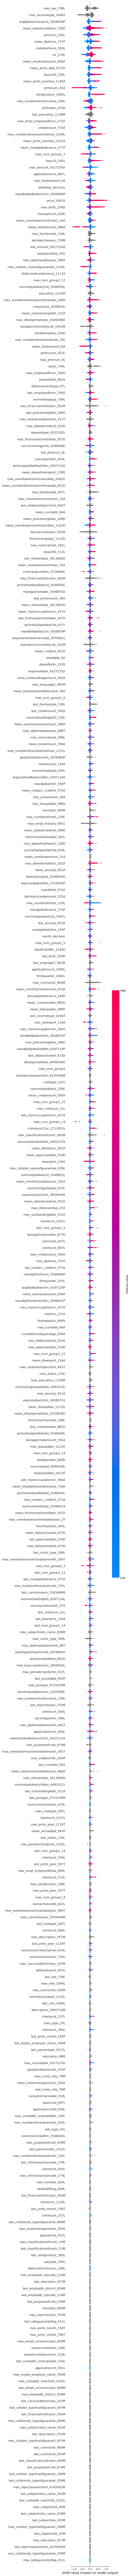

In [21]:
sample_indices = np.random.choice(X.index, 25000, replace=False)
X_sample = X.loc[sample_indices]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# SHAP Summary Bee Swarm Plot
plt.figure()
shap.summary_plot(shap_values, X_sample, plot_type="dot", max_display=X_sample.shape[1], show=False)

<Figure size 1000x800 with 0 Axes>

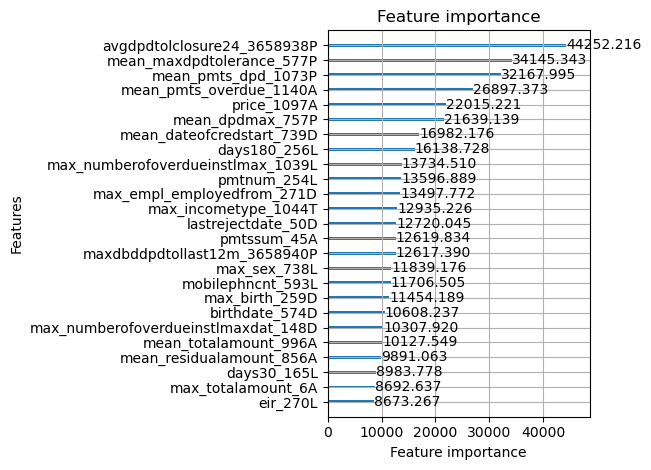

In [52]:
# Feature Importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, max_num_features=25, importance_type='gain')
plt.tight_layout() 

Посмотрим какой смысл у этих признаков

In [55]:
feature_definitions = pd.read_csv("feature_definitions.csv")

In [60]:
booster = model.booster_
gains = booster.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()
feature_gains_dict = dict(zip(feature_names, gains))
sorted_features_by_gain = sorted(feature_gains_dict.items(), key=lambda x: x[1], reverse=True)
feature_importance_lst = [feature[0] for feature in sorted_features_by_gain]

In [63]:
for feature in feature_importance_lst[:25]:
    # Query def
    description_row = feature_definitions.query(f"Variable == '{feature}'")
    if not description_row.empty:
        description = description_row['Description'].values[0]
        print(f"{feature}: {description}")
    # As far as we've added mean/max/min agg values, we need to split new features
    else:
        base_feature = feature.split('_', 1)[-1] if '_' in feature else feature
        description_row = feature_definitions.query(f"Variable == '{base_feature}'")
        if not description_row.empty:
            description = description_row['Description'].values[0]
            print(f"{feature} (original: {base_feature}): {description}")
        else:
            print(f"Description for {feature} (attempted base: {base_feature}) not found.")

avgdpdtolclosure24_3658938P: Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date.
mean_maxdpdtolerance_577P (original: maxdpdtolerance_577P): Maximum DPD with tolerance (on previous application/s).
mean_pmts_dpd_1073P (original: pmts_dpd_1073P): Days past due of the payment for the active contract (num_group1 - existing contract, num_group2 - payment).
mean_pmts_overdue_1140A (original: pmts_overdue_1140A): Overdue payment for an active contract (num_group1 - existing contract, num_group2 - payment).
price_1097A: Credit price.
mean_dpdmax_757P (original: dpdmax_757P): Maximum days past due for a closed contract.
mean_dateofcredstart_739D (original: dateofcredstart_739D): Start date of a closed credit contract.
days180_256L: Number of credit bureau queries for last 180 days.
max_numberofoverdueinstlmax_1039L (original: numberofo

Из представленных графиков и описания можно заметить, что признаки связанные с кредитной историей / финансовой стороной вносят наибольший вклад, что логично с точки зрения оценки возврата кредита. Что в целом подвтерждает ожидания, чем точнее модель улавливает зависимость связанную с платежеспособностью клиента, тем точнее будет предикшн. 

### 2. EDA 
Наблюдения при анализе данных и прочие находки (до 5 баллов).